<a href="https://colab.research.google.com/github/satvik-27199/HACTION-RECOGNITON/blob/main/DEPTH_SKE_INE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
import scipy.io
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns


In [ ]:
import numpy as np
import cv2

MHI_DURATION = 50
DEFAULT_THRESHOLD = 32


def main():

    live_video = False
    video_src = 0
    if not live_video:
        video_src = "/content/drive/MyDrive/color/a1_s3_t2_color copy.avi".replace('\\', '/')
        video_src = "/content/drive/MyDrive/color/a1_s3_t2_color copy.avi".replace('\\', '/')

    cv2.namedWindow('motion-history')
    cv2.namedWindow('raw')
    cv2.moveWindow('raw', 200, 0)

    cam = cv2.VideoCapture(video_src)
    ret, frame = cam.read()
    h, w = frame.shape[:2]
    prev_frame = frame.copy()
    motion_history = np.zeros((h, w), np.float32)
    timestamp = 0
    while True:
        ret, frame = cam.read()
        if not ret:
            break
        frame_diff = cv2.absdiff(frame, prev_frame)
        gray_diff = cv2.cvtColor(frame_diff, cv2.COLOR_BGR2GRAY)
        ret, fgmask = cv2.threshold(gray_diff, DEFAULT_THRESHOLD, 1, cv2.THRESH_BINARY)
        timestamp += 1

        # update motion history
        cv2.motempl.updateMotionHistory(fgmask, motion_history, timestamp, MHI_DURATION)

        # normalize motion history
        mh = np.uint8(np.clip((motion_history - (timestamp - MHI_DURATION)) / MHI_DURATION, 0, 1) * 255)
        cv2.imshow('motion-history', mh)
        cv2.imshow('raw', frame)

        prev_frame = frame.copy()
        if 0xFF & cv2.waitKey(5) == 27:
            break

    cv2.destroyAllWindows()


if __name__ == "__main__":
    main()

In [ ]:
action_names = ['Swipe left','Swipe right','Wave','Clap','Throw','Arm cross','Basketball shoot',
                'Draw X','Draw circle (clockwise)','Draw circle (counter clockwise)','Draw triangle',
                'Bowling','Boxing','Baseball swing','Tennis swing','Arm curl','Tennis serve','Push',
                'Knock','Catch','Pickup and throw','Jog','Walk','Sit to stand','Stand to sit','Lunge','Squat']

In [ ]:
path = '/content/drive/MyDrive/{0}/a{1}_s{2}_t{3}_{4}.mat'

In [ ]:

# Define actionID, subjectID and sampleID
aID = 2
sID = 1
tID = 1

# Create paths for Depth, Skeleton and Inertial Sensor files
Dpath = path.format('Depth',aID,sID,tID,'depth')
Spath = path.format('Skeleton',aID,sID,tID,'skeleton')
Ipath = path.format('Inertial',aID,sID,tID,'inertial')

In [ ]:

# read .MAT file for Dpath
matD = scipy.io.loadmat(Dpath)

# Obtain d_depth from matD dictionary.
D = matD['d_depth']

# Get number of frames based on 3rd dimension of matrix
numFrames = D.shape[-1]
print('Total number of frames: ', numFrames)

NameError: ignored

In [ ]:
fig = plt.figure()

hw=0.3
index = 0;

# Calculate number of rows
nrows = int(np.floor(numFrames/8))
for j in range(0,nrows):
    for i in range(0,8):
        ax = fig.add_axes([(i+1)*hw, (j+1)*hw, hw, hw],
                           xticklabels=[])

        ax.imshow(D[:,:,index])
        index +=1

In [ ]:
def average_frame(D):
    D1 = D.max(axis=2)
    D2 = D.min(axis=2)
    Dmid = D1+D2
    # Option 2 is averaging all values which is not so effective.
    #Dmid = np.mean(D,axis=2)
    # Normalise between 0 - 1
    Dmid = Dmid/np.max(Dmid)
    return Dmid

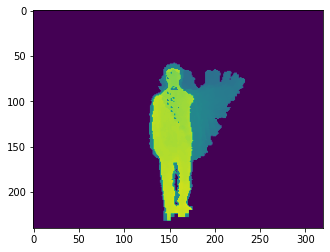

In [ ]:
# Call feature extractor function
Dmid = average_frame(D)
%matplotlib inline
plt.imshow(Dmid)

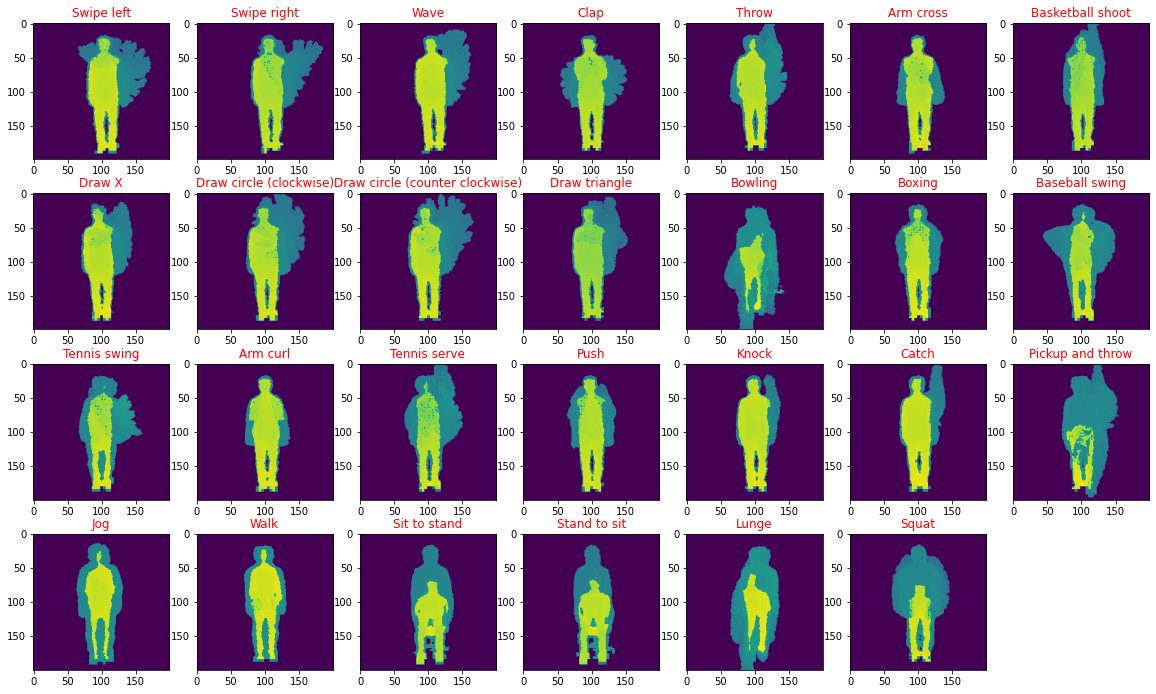

In [ ]:
fig = plt.figure(figsize=(20,12))
# imstack = np.empty((200,200))
for aID  in range(1,28):
    Dpath = path.format('Depth',aID,sID,tID,'depth')
    
    # read .MAT file for Dpath
    matD = scipy.io.loadmat(Dpath)

    # Obtain d_depth from matD dictionary.
    D = matD['d_depth']
    
    Dmid = average_frame(D)
    
    Dcrop = Dmid[40:,50:250]
 
    # imstack = np.dstack((imstack,Dcrop))

    plt.subplot(4,7, aID)
    plt.imshow(Dcrop)
    plt.title(action_names[aID-1],color = 'r')

In [ ]:
%%time
fig = plt.figure(figsize=(15,15))
imstack = np.empty((200,200))
Dtarget = []
for aID  in range(1,28):
    for sID in range(1,9):
        for tID in range(1,5):
            Dpath = path.format('Depth',aID,sID,tID,'depth')

            # read .MAT file for Dpath
            matD = scipy.io.loadmat(Dpath)

            # Obtain d_depth from matD dictionary.
            D = matD['d_depth']

            Dmid = average_frame(D)

            Dcrop = Dmid[40:,50:250]

            imstack = np.dstack((imstack,Dcrop))

            Dtarget.append(aID-1)
            
Dtarget = np.array(Dtarget)

CPU times: user 1min 3s, sys: 1.74 s, total: 1min 5s
Wall time: 6min 14s


<Figure size 1080x1080 with 0 Axes>

In [ ]:
print('The shape of input Depth data:',imstack.shape)

The shape of input Depth data: (200, 200, 865)


In [ ]:
imstack_norm=np.rollaxis(imstack,2,0)
imstack_norm.shape

(865, 200, 200)

In [ ]:
# Remove first entry which is empty
imstack_norm = imstack_norm[1:,:,:]
imstack_norm.shape

(864, 200, 200)

In [ ]:
# read .MAT file for Skeleton
matS = scipy.io.loadmat(Spath)

In [ ]:
# GEt skeleton data from dictionary
S = matS['d_skel']
# Get number of frames based on 3rd dimension of matrix
numFrames =S.shape[-1]

In [ ]:
def plot_im_skeleton(skeleton,ax):
    ''' This function defines the bone list and plot the skeleton from given cordinates'''

#     bone_list = [[0,1],[1,20],[20, 2], [2, 3], [2, 4], [4, 5], [5, 6], [6,7],[2, 8], [8,9], [9,10], [10, 11], 
#             [0,12],[12,13],[13, 14], [14, 15],[0,16],[16, 17], [17,18], [18, 19], [7, 21],[7,22],[11,23],[11,24]]#, [11, 22], [12, 13], ,[22,23],[23,24],[24,25]]
    bone_list = [[0,1],[1,2], [2, 3], [1, 4], [4, 5], [5, 6], [6,7],[1, 8], [8,9], [9,10], [10, 11], 
            [3,12],[12,13],[13, 14], [14, 15],[3,16],[16, 17], [17,18], [18, 19]]#, [11, 22], [12, 13], ,[22,23],[23,24],[24,25]]

    x = skeleton[:, 0]
    y = skeleton[:, 1]
    sc = ax.scatter(x, y, s=40,)
    for bone in bone_list:
        ax.plot([x[bone[0]], x[bone[1]]], [y[bone[0]], y[bone[1]]], 'r')

In [ ]:

def plot_3D_skeleton(skeleton,ax):
    ''' This function defines the bone list and plot the skeleton from given cordinates'''

#     bone_list = [[0,1],[1,2], [2, 3], [2, 4], [4, 5], [5, 6], [6,7],[2, 8], [8,9], [9,10], [10, 11], 
#             [0,12],[12,13],[13, 14], [14, 15],[0,16],[16, 17], [17,18], [18, 19], [7, 21],[7,22],[11,23],[11,24]]#, [11, 22], [12, 13], ,[22,23],[23,24],[24,25]]
    bone_list = [[0,1],[1,2], [2, 3], [1, 4], [4, 5], [5, 6], [6,7],[1, 8], [8,9], [9,10], [10, 11], 
            [3,12],[12,13],[13, 14], [14, 15],[3,16],[16, 17], [17,18], [18, 19]]#, [11, 22], [12, 13], ,[22,23],[23,24],[24,25]]

    x = skeleton[:, 0]
    z = skeleton[:, 1]
    y = skeleton[:, 2]
    sc = ax.scatter(x, y, z, s=20)
    for bone in bone_list:
        ax.plot([x[bone[0]], x[bone[1]]], [y[bone[0]], y[bone[1]]], [z[bone[0]], z[bone[1]]], 'b')

In [ ]:
def interp_vals(yin,numFrames):
    ''' This function interpolate Values of sensor according to number of frames'''
    xin = np.linspace(0, numFrames, len(yin))
    xnew = np.arange(0, numFrames)
    ynew = np.interp(xnew, xin, yin)
    return ynew

In [ ]:
def norm_vals(x):
    '''Function to normalise any values between 0 to 1'''
    x = x-np.min(x)
    x = x/np.max(x)
    return x

In [ ]:
def extract_features(S,flength,spoints):
    ''' This function takes x,y and z cordinate of specified skeleton joint and interpolate all values to given flength, 
    Finally normalise all values between 0-1 and return it as feature matrix'''
    feature_matrix = np.zeros((len(spoints)*3,flength))
    for i in range(len(spoints)):
        # Get X values for all frames
        sx = S[spoints[i],0,:]

        # Get Y values for all frames
        sy = S[spoints[i],1,:]

        # Get Z values for all frames
        sz = S[spoints[i],2,:]

        # Interpolate values
        sxi = interp_vals(sx,flength)
        syi = interp_vals(sy,flength)
        szi = interp_vals(sz,flength)

        # Normalise values
        sxi = norm_vals(sxi)
        syi = norm_vals(syi)
        szi = norm_vals(szi)
        
        # Store values into feature matrix
        feature_matrix[i*3,:] = sxi
        feature_matrix[i*3+1,:] = syi
        feature_matrix[i*3+2,:] = szi    
        
    return feature_matrix

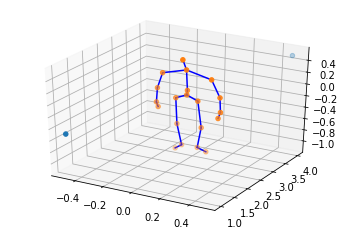

In [ ]:
ax = plt.axes(projection='3d')
ax.scatter([-0.5, 0.5],[1,4],[-0.5,0.5],)
plot_3D_skeleton(S[:,:,0],ax)

In [ ]:
# Skeleton Values
%matplotlib notebook
#calling it a second time may prevent some graphics errors
%matplotlib notebook
%matplotlib notebook
for i in range(numFrames):
    skeleton = S[:,:,i] 
    ax = plt.axes(projection='3d')
    ax.scatter([-0.5, 0.5],[1,4],[-0.5,0.5],)
    plot_3D_skeleton(skeleton,ax)
    ax.mouse_init()
    plt.show()
    ax.set_title(['Frame: ',i])
    plt.pause(0.05)

<IPython.core.display.Javascript object>

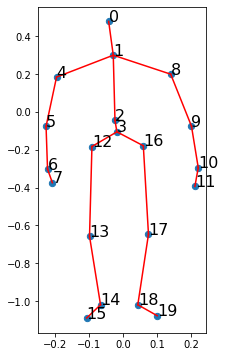

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(3,6))
plot_im_skeleton(S[:,:,0],ax)
for i in range(20):
    plt.text(S[i,0,0],S[i,1,0],i,fontsize = 16)

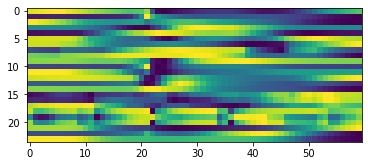

In [ ]:
%matplotlib inline
# Define feature length
flength = 60
# Skeleton points to be considered for features
spoints = [1,11,7,8,4,15,19,3]

# Call function to extract feature matrix
fm = extract_features(S,flength,spoints)

# show image
plt.imshow(fm)

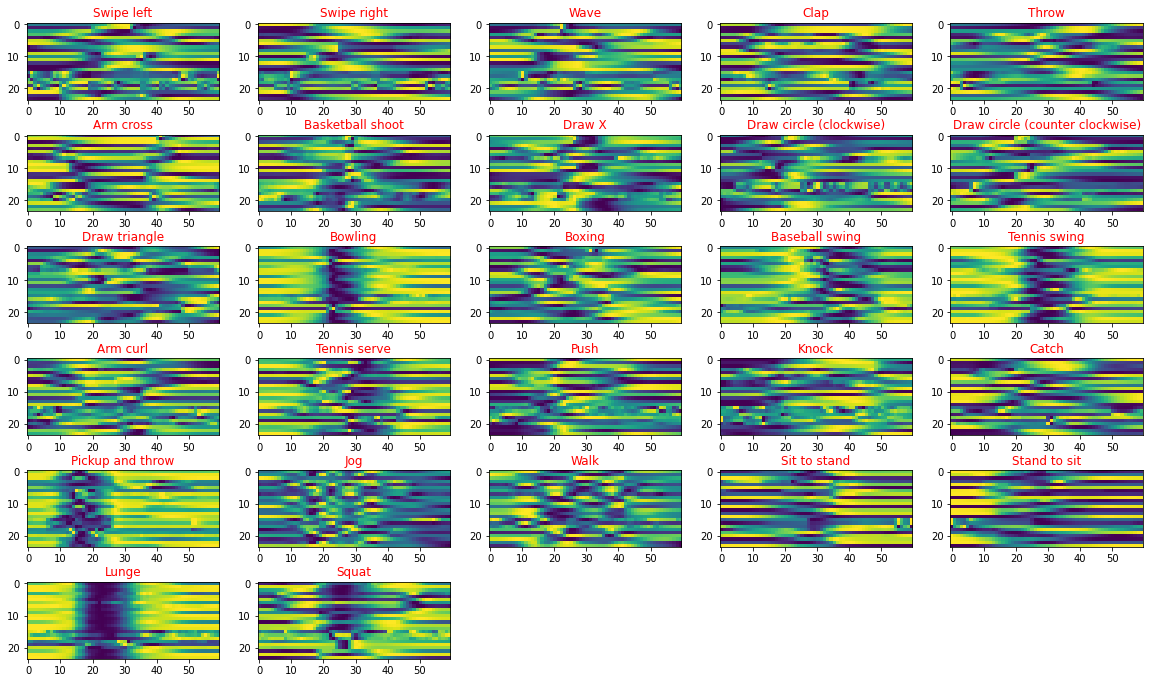

In [ ]:
%matplotlib inline
# Define feature length
flength = 60
# Skeleton points to be considered for features
spoints = [1,11,7,8,4,15,19,3]

fig = plt.figure(figsize=(20,12))
# imstack = np.empty((200,200))
for aID  in range(1,28):
    Spath = path.format('Skeleton',aID,sID,tID,'skeleton')
    
    # read .MAT file for Dpath
    matS = scipy.io.loadmat(Spath)

    # Obtain d_depth from matD dictionary.
    S = matS['d_skel']
    
    fm = extract_features(S,flength,spoints)
    
    plt.subplot(6,5, aID)
    plt.imshow(fm)
    plt.title(action_names[aID-1],color='r')

In [ ]:
%%time
# Define feature length
flength = 60
# Skeleton points to be considered for features
spoints = [1,11,7,8,4,15,19,3]

Sstack = np.zeros((len(spoints)*3,flength))
Starget = []
for aID  in range(1,28):
    for sID in range(1,9):
        for tID in range(1,5):
            Spath = path.format('Skeleton',aID,sID,tID,'skeleton')
    
            # read .MAT file for Dpath
            matS = scipy.io.loadmat(Spath)

            # Obtain d_depth from matD dictionary.
            S = matS['d_skel']

            fm = extract_features(S,flength,spoints)
            
            Sstack = np.dstack((Sstack,fm))

            Starget.append(aID-1)
            
Starget = np.array(Starget)

CPU times: user 3.87 s, sys: 282 ms, total: 4.16 s
Wall time: 4min 46s


In [ ]:
Sstack_norm=np.rollaxis(Sstack,2,0)
Sstack_norm.shape

(865, 24, 60)

In [ ]:
Sstack_norm = Sstack_norm[1:,:,:]

In [ ]:
mat_inn = scipy.io.loadmat(Ipath)

In [ ]:
d_iner = mat_inn['d_iner']

In [ ]:
def interpolate_cols(d_iner,interpval=60):
    # Intialise empty matrix
    imat = np.zeros((interpval,d_iner.shape[1]))
    for i in range(d_iner.shape[1]):
        val = d_iner[:,i]
        ival = interp_vals(val,interpval)
        
        # normalise values between 0-1
        ival = norm_vals(ival)
        
        # Store values back to matrix
        imat[:,i] = ival
    return imat

In [ ]:
imat = interpolate_cols(d_iner,60)
imat.shape

(60, 6)

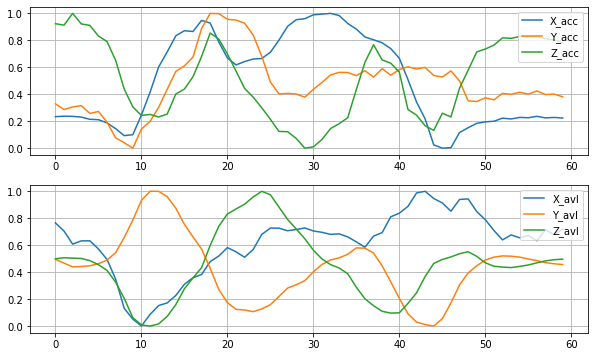

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(10,6))
ax[0].plot(imat[:,0:3])
ax[0].legend(labels=['X_acc','Y_acc','Z_acc'],loc='upper right')
ax[0].grid(True)
ax[1].plot(imat[:,3:])
ax[1].legend(labels=['X_avl','Y_avl','Z_avl'],loc='upper right')
ax[1].grid(True)
# plt.legend()

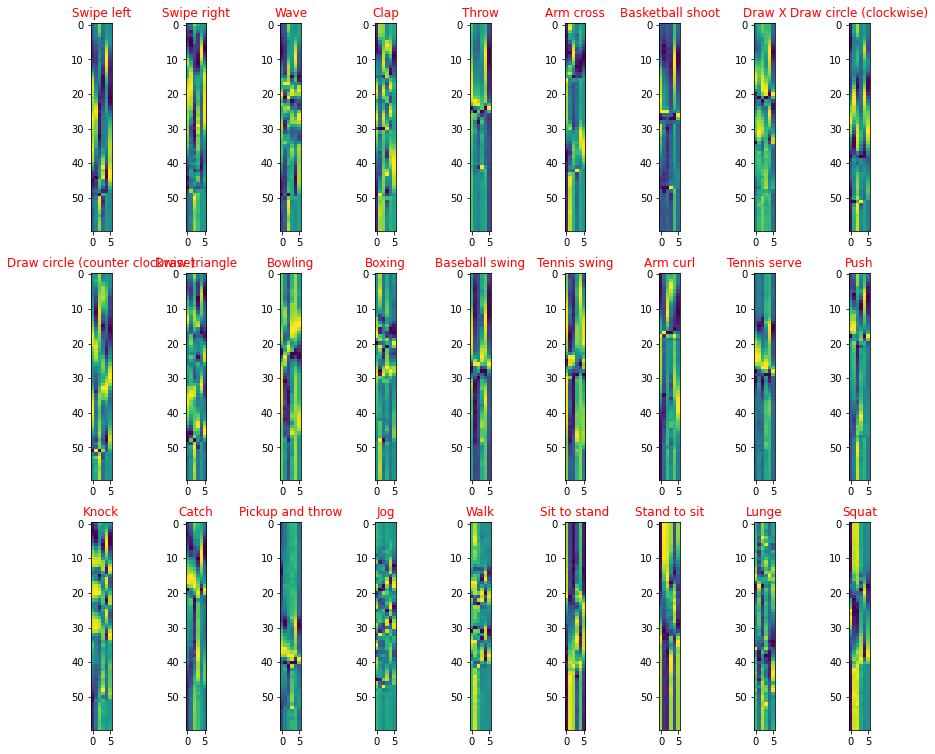

In [ ]:
%matplotlib inline
# Define feature length
flength = 60

fig = plt.figure(figsize=(15,13))
# imstack = np.empty((200,200))
for aID  in range(1,28):
    Ipath = path.format('Inertial',aID,sID,tID,'inertial')

    # Inertial
    mat_inn = scipy.io.loadmat(Ipath)

    # Get sensor value
    d_iner = mat_inn['d_iner']

    # interpolate and normalise all columns
    fi = interpolate_cols(d_iner,flength)
    
    plt.subplot(3,9, aID)
    plt.imshow(fi)
    plt.title(action_names[aID-1],color='r')

In [ ]:

%%time
# Define feature length
flength = 60

Istack = np.zeros((flength,6))
Itarget = []
for aID  in range(1,28):
    for sID in range(1,9):
        for tID in range(1,5):
            Ipath = path.format('Inertial',aID,sID,tID,'inertial')
            
            # Inertial
            mat_inn = scipy.io.loadmat(Ipath)

            # Get sensor value
            d_iner = mat_inn['d_iner']

            # interpolate and normalise all columns
            fi = interpolate_cols(d_iner,flength)
            
            Istack = np.dstack((Istack,fi))

            Itarget.append(aID-1)
            
# Delete first entry
Istack = Istack[:,:,1:]
Itarget = np.array(Itarget)

CPU times: user 2.32 s, sys: 285 ms, total: 2.6 s
Wall time: 5min 57s


In [ ]:
Istack.shape

(60, 6, 864)

In [ ]:
Istack_norm=np.rollaxis(Istack,2,0)
Istack_norm.shape

(864, 60, 6)

In [ ]:
Sstack_norm.shape

(864, 24, 60)

In [ ]:
def cal_results(Dy_test,Fy_pred):
    CM = confusion_matrix(Dy_test,Fy_pred)
    accuracy = np.sum(np.diag(CM))/np.sum(CM)
    recall = np.mean(np.diag(CM) / np.sum(CM, axis = 1))
    precision = np.mean(np.diag(CM) / np.sum(CM, axis = 0))
    return accuracy,recall,precision

In [ ]:
# Define test size
Tsize= 0.66
DX_train, DX_test, Dy_train, Dy_test = train_test_split(imstack_norm,Dtarget, test_size=Tsize,
                                                    random_state=42,stratify=Dtarget)
SX_train, SX_test, Sy_train, Sy_test = train_test_split(Sstack_norm,Starget, test_size=Tsize,
                                                    random_state=42,stratify=Starget)
IX_train, IX_test, Iy_train, Iy_test = train_test_split(Sstack_norm,Itarget, test_size=Tsize,
                                                    random_state=42,stratify=Itarget)

In [ ]:
DX_test.shape

(571, 200, 200)

In [ ]:

def evaluate_model_1(X_train,X_test,y_train,y_test):
    '''This function train model 1 based on X_train and y_train'''
    model = keras.Sequential([
        keras.layers.Flatten(input_shape=X_train.shape[1:]),
        keras.layers.Dense(128,activation=tf.nn.relu),
        keras.layers.Dense(128,activation=tf.nn.relu),
        keras.layers.Dense(27,activation=tf.nn.softmax)
    ])
    model.compile(optimizer = tf.optimizers.Adam(),
                 loss = 'sparse_categorical_crossentropy',
                 metrics = ['accuracy'])
    # model.fit(imstack_norm,np.array(target),epochs=10)
    model.fit(X_train,y_train,epochs=20)
    return model

In [ ]:

def evaluate_model_2(X_train,X_test,y_train,y_test):
    '''This function train model 1 based on X_train and y_train'''
    model = keras.Sequential([
        keras.layers.Flatten(input_shape=X_train.shape[1:]),
        keras.layers.Dense(128,activation=tf.nn.conv2d),
        keras.layers.Dense(128,activation=tf.nn.relu),
        keras.layers.Dense(27,activation=tf.nn.max_pool)
    ])
    model.compile(optimizer = tf.optimizers.Adam(),
                 loss = 'sparse_categorical_crossentropy',
                 metrics = ['accuracy'])
    # model.fit(imstack_norm,np.array(target),epochs=10)
    model.fit(X_train,y_train,epochs=20)
    return model

In [ ]:
y_pred = np.ones(len(Dtarget))
CM = confusion_matrix(Dtarget,y_pred)
accuracyb = np.sum(np.diag(CM))/np.sum(CM)
recallb = np.mean(np.diag(CM) / np.sum(CM, axis = 1))
precisionb = np.mean(np.diag(CM) / np.sum(CM, axis = 0))
print('Baseline Accuracy',accuracyb)
print('Baseline Recall',recallb)
print('Baseline Precision',precisionb)

Baseline Accuracy 0.037037037037037035
Baseline Recall 0.037037037037037035
Baseline Precision nan


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


In [ ]:
Dmodel= evaluate_model_1(DX_train,DX_test,Dy_train,Dy_test)
Smodel = evaluate_model_1(SX_train,SX_test,Sy_train,Sy_test)
Imodel = evaluate_model_1(IX_train,IX_test,Iy_train,Iy_test)

Epoch 1/20
10/10 [==============================] - 3s 6ms/step - loss: 5.0544 - accuracy: 0.0307
Epoch 2/20
10/10 [==============================] - 0s 5ms/step - loss: 3.6805 - accuracy: 0.0831
Epoch 3/20
10/10 [==============================] - 0s 4ms/step - loss: 2.9128 - accuracy: 0.1436
Epoch 4/20
10/10 [==============================] - 0s 4ms/step - loss: 2.8111 - accuracy: 0.1656
Epoch 5/20
10/10 [==============================] - 0s 4ms/step - loss: 2.5273 - accuracy: 0.2210
Epoch 6/20
10/10 [==============================] - 0s 4ms/step - loss: 2.2857 - accuracy: 0.2804
Epoch 7/20
10/10 [==============================] - 0s 4ms/step - loss: 1.9465 - accuracy: 0.4325
Epoch 8/20
10/10 [==============================] - 0s 5ms/step - loss: 1.7262 - accuracy: 0.5051
Epoch 9/20
10/10 [==============================] - 0s 5ms/step - loss: 1.4711 - accuracy: 0.5795
Epoch 10/20
10/10 [==============================] - 0s 5ms/step - loss: 1.2383 - accuracy: 0.6683
Epoch 11/20
10/10 [

In [ ]:
def test_model(y_test,ypred):
    # Find position of maximum value to get predicted output
    y_pred = [np.argmax(i) for i in ypred]
    CM = confusion_matrix(y_test,y_pred)
    accuracy = np.sum(np.diag(CM))/np.sum(CM)
    recall = np.mean(np.diag(CM) / np.sum(CM, axis = 1))
    precision = np.mean(np.diag(CM) / np.sum(CM, axis = 0))
    return accuracy,recall,precision,CM

In [ ]:
# Evaluate all three models
Dypred = Dmodel.predict(DX_test)
Sypred = Smodel.predict(SX_test)
Iypred = Imodel.predict(IX_test)
Fypred = (Dypred+Sypred+Iypred)/3

In [ ]:
Dacc,Drec,Dpre,DCM = test_model(Dy_test,Dypred)
Sacc,Srec,Spre,SCM = test_model(Sy_test,Sypred)
Iacc,Irec,Ipre,ICM = test_model(Iy_test,Iypred)
Facc,Frec,Fpre,FCM = test_model(Dy_test,Fypred)

In [ ]:
print(Dacc,Sacc,Iacc,Facc)

0.6234676007005254 0.7688266199649737 0.8056042031523643 0.8598949211908932


In [ ]:
# %% time
accmat = np.zeros((4,4))
recmat = np.zeros((4,4))
premat = np.zeros((4,4))

index = 0
for Tsize in np.arange(0.2,0.8,0.2):

    DX_train, DX_test, Dy_train, Dy_test = train_test_split(imstack_norm,Dtarget, test_size=Tsize,
                                                        random_state=42,stratify=Dtarget)
    SX_train, SX_test, Sy_train, Sy_test = train_test_split(Sstack_norm,Starget, test_size=Tsize,
                                                        random_state=42,stratify=Starget)
    IX_train, IX_test, Iy_train, Iy_test = train_test_split(Sstack_norm,Itarget, test_size=Tsize,
                                                        random_state=42,stratify=Itarget)

    # Train models
    Dmodel= evaluate_model_1(DX_train,DX_test,Dy_train,Dy_test)
    Smodel = evaluate_model_1(SX_train,SX_test,Sy_train,Sy_test)
    Imodel = evaluate_model_1(IX_train,IX_test,Iy_train,Iy_test)

    # Evaluate all three models
    Dypred = Dmodel.predict(DX_test)
    Sypred = Smodel.predict(SX_test)
    Iypred = Imodel.predict(IX_test)

    # Create fusion result
    Fypred = (Dypred+Sypred+Iypred)/3

    Dacc,Drec,Dpre,DCM = test_model(Dy_test,Dypred)
    Sacc,Srec,Spre,SCM = test_model(Sy_test,Sypred)
    Iacc,Irec,Ipre,ICM = test_model(Iy_test,Iypred)
    Facc,Frec,Fpre,FCM = test_model(Dy_test,Fypred)
    
    accmat[index,:] = [Dacc,Sacc,Iacc,Facc]
    recmat[index,:] = [Drec,Srec,Irec,Frec]
    premat[index,:] = [Dpre,Spre,Ipre,Fpre]
    index+=1

Epoch 1/20
22/22 [==============================] - 0s 5ms/step - loss: 4.4472 - accuracy: 0.0535
Epoch 2/20
22/22 [==============================] - 0s 5ms/step - loss: 2.7626 - accuracy: 0.2215
Epoch 3/20
22/22 [==============================] - 0s 5ms/step - loss: 2.1088 - accuracy: 0.3922
Epoch 4/20
22/22 [==============================] - 0s 5ms/step - loss: 1.7696 - accuracy: 0.4537
Epoch 5/20
22/22 [==============================] - 0s 5ms/step - loss: 1.2910 - accuracy: 0.6187
Epoch 6/20
22/22 [==============================] - 0s 5ms/step - loss: 0.9906 - accuracy: 0.6991
Epoch 7/20
22/22 [==============================] - 0s 6ms/step - loss: 0.8752 - accuracy: 0.7524
Epoch 8/20
22/22 [==============================] - 0s 5ms/step - loss: 0.6789 - accuracy: 0.8050
Epoch 9/20
22/22 [==============================] - 0s 5ms/step - loss: 0.5598 - accuracy: 0.8353
Epoch 10/20
22/22 [==============================] - 0s 5ms/step - loss: 0.4964 - accuracy: 0.8231
Epoch 11/20
22/22 [

In [ ]:
print(accmat)

[[0.80924855 0.84393064 0.83236994 0.90751445]
 [0.72254335 0.85260116 0.86416185 0.88150289]
 [0.70327553 0.78805395 0.82466281 0.87668593]
 [0.48410405 0.68063584 0.70953757 0.75144509]]


In [ ]:
print(recmat)

[[0.81216931 0.84656085 0.83421517 0.90740741]
 [0.72364672 0.85208927 0.8637227  0.88129155]
 [0.70341131 0.78927875 0.82524366 0.87709552]
 [0.48529915 0.68096866 0.71042735 0.75213675]]


In [ ]:
print(premat)

[[0.82369195 0.87607824 0.82497061 0.92389771]
 [0.77799112 0.86253844 0.87169173 0.89057143]
 [0.76060394 0.81309604 0.83176024 0.87705514]
 [0.54011818 0.68893607 0.72268684 0.76383776]]


In [ ]:
accdf = pd.DataFrame(accmat,columns=['Depth','Skeleton','Sensor','Fusion'],index=['0.2','0.4','0.6','0.8'])
accdf

,Depth,Skeleton,Sensor,Fusion
0.2,0.809249,0.843931,0.832370,0.907514
0.4,0.722543,0.852601,0.864162,0.881503
0.6,0.703276,0.788054,0.824663,0.876686
0.8,0.484104,0.680636,0.709538,0.751445


Text(0.5, 1.0, 'Accuracy Comparison')

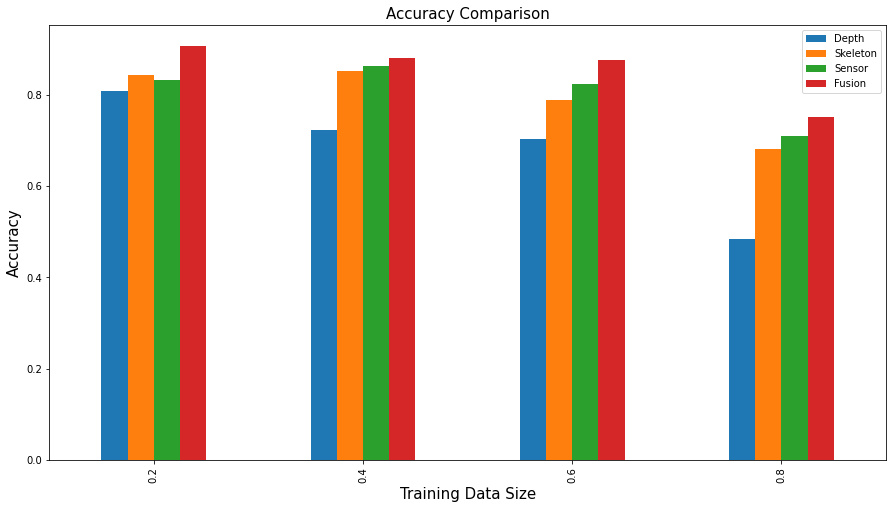

In [ ]:
accdf = pd.DataFrame(accmat,columns=['Depth','Skeleton','Sensor','Fusion'],index=['0.2','0.4','0.6','0.8'])
accdf.plot(kind='bar',figsize=(15,8))
plt.xlabel('Training Data Size',fontsize=15)
plt.ylabel('Accuracy',fontsize=15)
plt.title('Accuracy Comparison',fontsize = 15)

Text(0.5, 1.0, 'Precision Comparison')

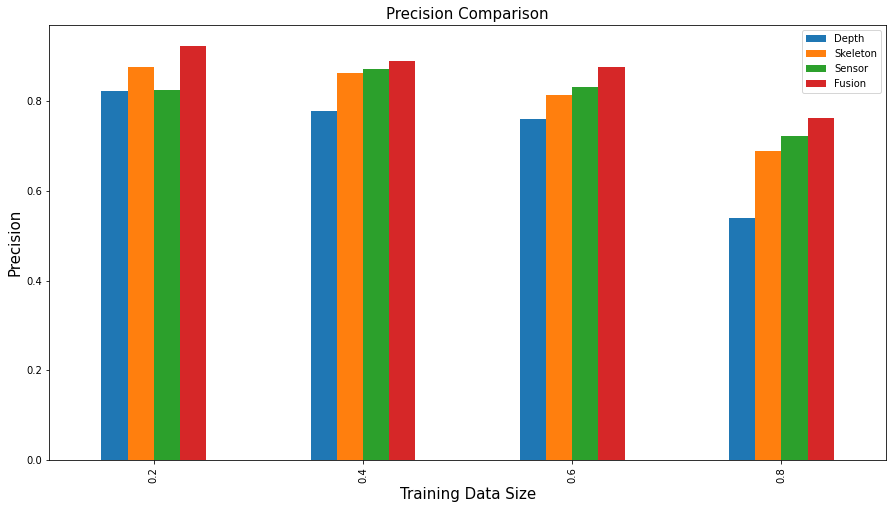

In [ ]:

predf = pd.DataFrame(premat,columns=['Depth','Skeleton','Sensor','Fusion'],index=['0.2','0.4','0.6','0.8'])
predf.plot(kind='bar',figsize=(15,8))
plt.xlabel('Training Data Size',fontsize=15)
plt.ylabel('Precision',fontsize=15)
plt.title('Precision Comparison',fontsize = 15)

Text(0.5, 1.0, 'Recall Comparison')

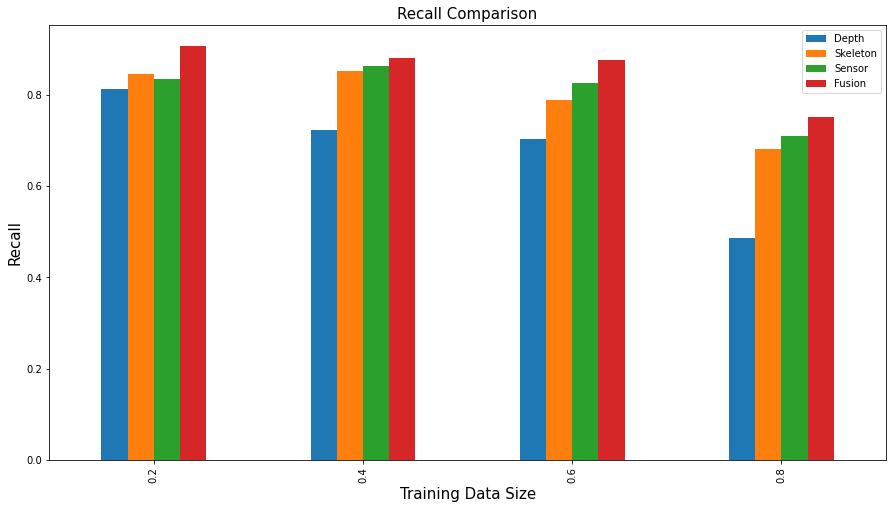

In [ ]:

recdf = pd.DataFrame(recmat,columns=['Depth','Skeleton','Sensor','Fusion'],index=['0.2','0.4','0.6','0.8'])
recdf.plot(kind='bar',figsize=(15,8))
plt.xlabel('Training Data Size',fontsize=15)
plt.ylabel('Recall',fontsize=15)
plt.title('Recall Comparison',fontsize = 15)